In [1]:
import sys
sys.path.append('../Data_Feature')
sys.path.append('../Datasets')
print(sys.path)
import numpy as np
import os
import requests
import seaborn as sns
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB # or GaussianNB if your data is normalized and continuous
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, make_scorer, matthews_corrcoef, roc_curve, auc
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
import plotly.figure_factory as ff
import networkx as nx
#from Bio.KEGG.REST import kegg_find, kegg_get, kegg_link
from pyvis.network import Network
from pyvis.network import Network
from bioservices import KEGG
import zipfile 


'''
Data prep and feature mapping
'''


# Paths to your uploaded files
zip_file_path_KO = "C:/Users/eliah/Documents/Master/Eliah-Masters/Datasets/terms_COG.zip"
csv_file_name_KO = 'terms_COG.csv'
zip_file_path_traits = 'C:/Users/eliah/Documents/Master/Eliah-Masters/Datasets/reducedDataset.zip'
csv_file_name_traits = 'reducedDataset.csv'
# Read and preprocess KO terms
with zipfile.ZipFile(zip_file_path_KO, 'r') as zip_ref:
    with zip_ref.open(csv_file_name_KO) as file:
        KOs = pd.read_csv(file, index_col=0)

KOs['value'] = 1
X_terms = KOs.pivot_table(index='key', columns='COG', values='value', fill_value=0)


# Apply VarianceThreshold to remove constant features
selector = VarianceThreshold(threshold=0.02)
X_filtered = selector.fit_transform(X_terms)
X_filtered_df = pd.DataFrame(X_filtered, index=X_terms.index, columns=X_terms.columns[selector.get_support()])

# Optionally, inspect the variance of features to confirm removal
feature_variances = X_filtered_df.var()
print(f"Features with zero variance after filtering: {sum(feature_variances == 0)}")

# Read and preprocess traits data
with zipfile.ZipFile(zip_file_path_traits, 'r') as zip_ref:
    with zip_ref.open(csv_file_name_traits) as file:
        traits = pd.read_csv(file, sep=';')
traits['gram'] = traits['gram'].str.lower()

# Mapping of oxygen levels to a simplified classification
Gramstaining_mapping = {
    'positive': 'positive',
    'negative': 'negative',
    'nan': 'nan'  
}
traits['gram'] = traits['gram'].map(Gramstaining_mapping)


# Handling missing values and aggregating by key
y = traits.dropna(subset=['gram']).groupby('key').agg({'gram': lambda x: x.value_counts().index[0]})


# Find common keys after removing missing values
common_keys = X_filtered_df.index.intersection(y.index)

# Align X (features) and Y (labels) based on common keys
X_aligned = X_filtered_df.loc[common_keys]
Y_aligned = y.loc[common_keys].values.ravel()

# Ensures X_aligned and Y_aligned are aligned
assert X_aligned.shape[0] == len(Y_aligned), "X and Y are not aligned"

['c:\\Users\\eliah\\AppData\\Local\\Programs\\Python\\Python313\\python313.zip', 'c:\\Users\\eliah\\AppData\\Local\\Programs\\Python\\Python313\\DLLs', 'c:\\Users\\eliah\\AppData\\Local\\Programs\\Python\\Python313\\Lib', 'c:\\Users\\eliah\\AppData\\Local\\Programs\\Python\\Python313', '', 'C:\\Users\\eliah\\AppData\\Roaming\\Python\\Python313\\site-packages', 'C:\\Users\\eliah\\AppData\\Roaming\\Python\\Python313\\site-packages\\win32', 'C:\\Users\\eliah\\AppData\\Roaming\\Python\\Python313\\site-packages\\win32\\lib', 'C:\\Users\\eliah\\AppData\\Roaming\\Python\\Python313\\site-packages\\Pythonwin', 'c:\\Users\\eliah\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages', '../Data_Feature', '../Datasets']
Features with zero variance after filtering: 0


In [9]:
print(X_aligned)

COG   COG0001  COG0002  COG0003  COG0004  COG0005  COG0006  COG0007  COG0008  \
key                                                                            
1         0.0      0.0      1.0      0.0      1.0      1.0      0.0      1.0   
3         1.0      1.0      0.0      1.0      1.0      1.0      1.0      1.0   
4         0.0      1.0      1.0      1.0      0.0      1.0      0.0      1.0   
8         0.0      0.0      0.0      0.0      1.0      1.0      0.0      1.0   
14        1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0   
...       ...      ...      ...      ...      ...      ...      ...      ...   
3281      1.0      1.0      0.0      1.0      0.0      1.0      1.0      1.0   
3286      1.0      1.0      0.0      0.0      1.0      1.0      1.0      1.0   
3287      1.0      1.0      0.0      1.0      1.0      1.0      1.0      1.0   
3295      1.0      1.0      0.0      1.0      1.0      1.0      1.0      1.0   
3306      1.0      1.0      1.0      1.0

COG  COG0001  COG0002  COG0003  COG0004  COG0005  COG0006  COG0007  COG0008  \
key                                                                           
1        0.0      0.0      1.0      0.0      1.0      1.0      0.0      1.0   
3        1.0      1.0      0.0      1.0      1.0      1.0      1.0      1.0   
4        0.0      1.0      1.0      1.0      0.0      1.0      0.0      1.0   
8        0.0      0.0      0.0      0.0      1.0      1.0      0.0      1.0   
14       1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0   

COG  COG0009  COG0010  ...  COG5653  COG5654  COG5655  COG5658  COG5659  \
key                    ...                                                
1        1.0      0.0  ...      0.0      0.0      0.0      1.0      0.0   
3        1.0      1.0  ...      1.0      0.0      0.0      0.0      0.0   
4        1.0      1.0  ...      0.0      0.0      0.0      1.0      0.0   
8        1.0      0.0  ...      0.0      0.0      0.0      1.0      0.0

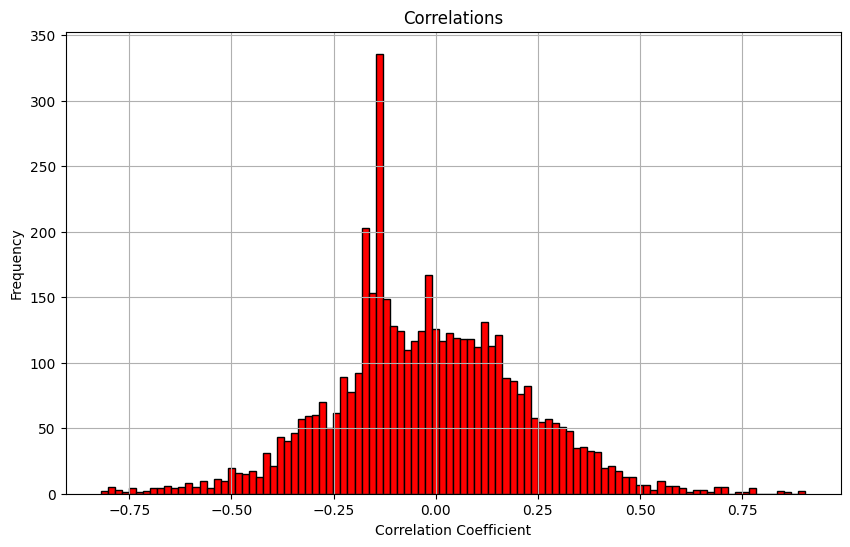

In [2]:
''' Calculating Pearsons coefficient'''

# Always look at data, right?
print(X_aligned.head())

'''Handelig data values'''

# Checking datatype for y_algned, i think
class_distribution = pd.Series(Y_aligned).value_counts()
print("Class distribution in Y_aligned:", class_distribution)

# Checks data label of Y algined
unique_labels = np.unique(Y_aligned)
print(f"Unique labels in Y_aligned: {unique_labels}")

# Initialize the LabelEncoder and transform the data from catagorical
label_encoder = LabelEncoder()
Y_aligned = label_encoder.fit_transform(Y_aligned)

# Check data once labelencoder is done
print(f"Data of Y_aligned: {np.unique(Y_aligned)}")


# Calculate Pearson correlation coefficients
corr_coefficients = [] # Collectes coefficents from X_aligned and Y_aligned calculations

# I should probably check how pearsons actually works
 

for column in X_aligned.columns: # Iterates over every column in X_aligned
    # Easier to check all the different collumns because its a pandas data frame
    # Interger indexing is cool but i dont like it
    r, p = pearsonr(X_aligned[column], Y_aligned)  
    corr_coefficients.append(r)


# PLotting
plt.figure(figsize=(10, 6))
plt.hist(corr_coefficients, bins=100, color='red', edgecolor='black')
plt.title('Correlations')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Fitting 5 folds for each of 189 candidates, totalling 945 fits
Best parameters found: {'estimator': SVC(random_state=42), 'estimator__C': 0.1, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf', 'select_k__k': 10}
Best cross-validation score: 0.975
Accuracy: <function accuracy_score at 0x0000012AF8B694E0>
Matthews Correlation Coefficient: 0.9393377067777824


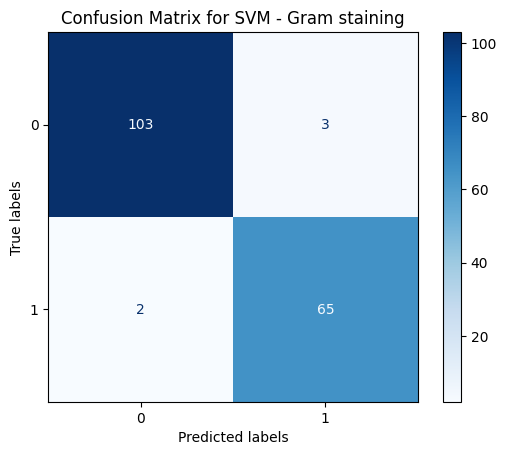

In [2]:
''' Pipeline implementation for Naive bayes and random forests'''

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_aligned, Y_aligned, test_size=0.3, random_state=42)

pipeline = Pipeline([
    ('select_k', SelectKBest(f_classif)),
    ('estimator', RandomForestClassifier())
])

# Define a parameter grid to search over
param_grid = [
    {
        'select_k__k': [10, 50, 100, 200, 300, 500, 1000],  # May need adjusting  100, 200, 300
        'estimator': [RandomForestClassifier(random_state=42)],
        'estimator__n_estimators': [100, 200],  
        'estimator__max_depth': [5, 10, None]  
    },
    {
        'select_k__k': [10, 50, 100, 200, 300, 500, 1000],  # May need adjusting  100, 200, 300
        'estimator': [SVC(random_state=42)],
        'estimator__C': [0.1, 1, 10],  
        'estimator__kernel': ['linear', 'rbf'], 
        'estimator__gamma': ['scale', 'auto']  
    },
    {
        'select_k__k': [10, 50, 100, 200, 300, 500, 1000],  # May need adjusting  100, 200, 300
        'estimator': [LogisticRegression()],
        'estimator__C': [0.01, 0.1, 1, 10, 100]
    },         
    {
        'select_k__k': [10, 50, 100, 200, 300, 500, 1000],  # May need adjusting  100, 200, 300
        'estimator': [BernoulliNB()],
        'estimator__alpha': [0.01, 0.1, 1.0, 10.0],  
        'estimator__binarize': [0.0]  # Is automatically applied
    }
]



''' Grid search '''

# Set up GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, Y_train)

print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))
print('Accuracy:', accuracy_score)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
Y_pred = best_model.predict(X_test)


'''MCC shenanigans'''

mcc = matthews_corrcoef(Y_test, Y_pred)
print(f"Matthews Correlation Coefficient: {mcc}")


# Display confusion matrix for the best model
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix for SVM - Gram staining')
plt.show()


Most selected COGS terms for predicting oxygen trait in hierchical manner based on randomforest classifier:
This is model based feature importance (uses models own feature importance score to evaluate most important ones)
Index(['COG1799', 'COG4775', 'COG1481', 'COG0763', 'COG0795', 'COG1847',
       'COG1461', 'COG1837', 'COG2877', 'COG2825'],
      dtype='object', name='COG')


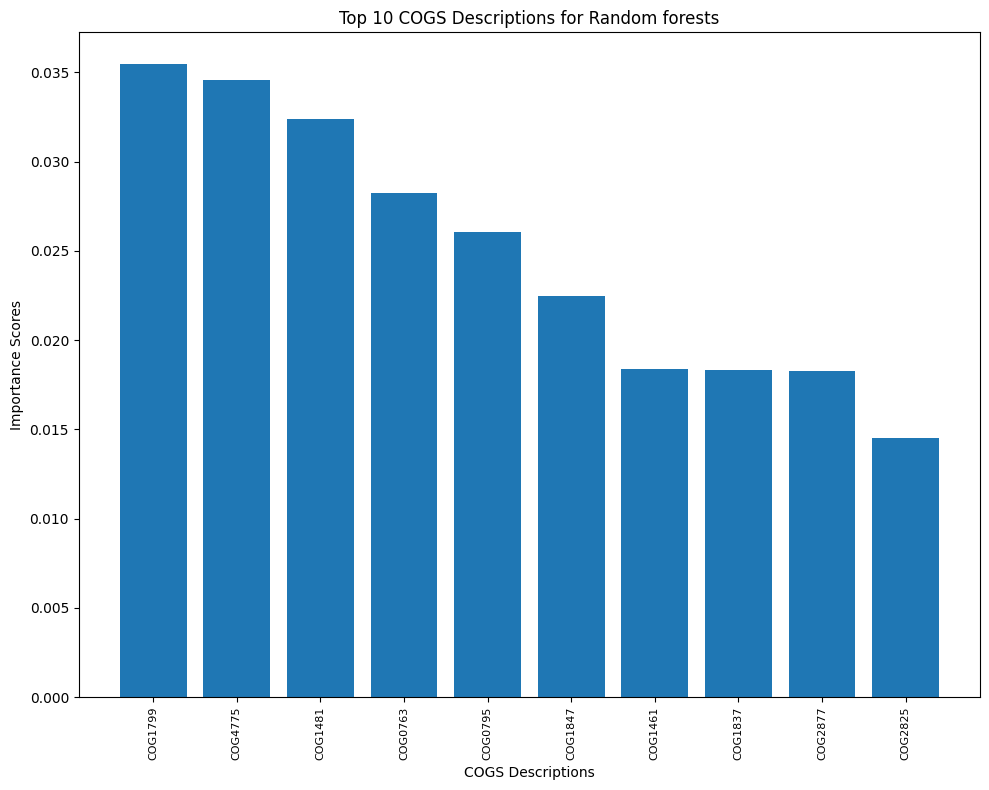

Most selected COGS terms for predicting oxygen trait in hierchical manner based on logistic regression:
This is model based feature importance (uses model's coefficients as importance scores)
Index(['COG3599', 'COG2885', 'COG0841', 'COG3649', 'COG2246', 'COG1799',
       'COG1538', 'COG1620', 'COG0053', 'COG1741'],
      dtype='object', name='COG')


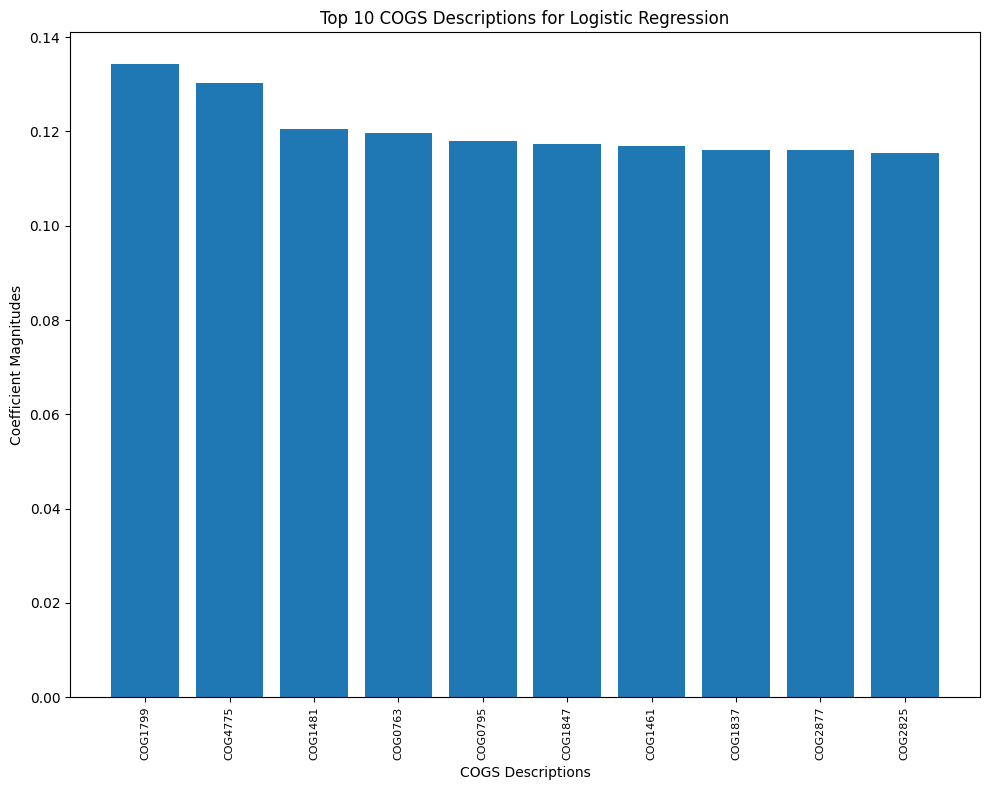

In [4]:
''' Model based feature importance score '''

#Fit a RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_aligned, Y_aligned)

#Rank features by their importances
feature_importances = model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

# Select the top 10 features
top_k_indices = sorted_indices[:10]
selected_features = X_aligned.columns[top_k_indices]

# Scores of selected features
sorted_scores = feature_importances[top_k_indices]

print("Most selected COGS terms for predicting oxygen trait in hierchical manner based on randomforest classifier:")
print("This is model based feature importance (uses models own feature importance score to evaluate most important ones)")
print(selected_features)

#Translate selected GO terms to their descriptions
# Need to find translation thingy

# Prepare labels and scores for plotting
labels = selected_features
sorted_labels = [labels[idx] for idx in range(len(labels))]

# Plotting with translated names
plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_labels)), sorted_scores)
plt.xticks(range(len(sorted_labels)), selected_features, rotation='vertical', fontsize=8)
plt.xlabel('COGS Descriptions')
plt.ylabel('Importance Scores')
plt.title('Top 10 COGS Descriptions for Random forests')
plt.tight_layout()
plt.show()


''' For logsitc regression'''

#Fit a LogisticRegression model
lr_model = LogisticRegression(solver="liblinear")
lr_model.fit(X_aligned, Y_aligned)

#Rank features by their coefficients
lr_coefficients = lr_model.coef_[0]
sorted_indices_lr = np.argsort(np.abs(lr_coefficients))[::-1]

# Select the top 10 features
top_k_indices_lr = sorted_indices_lr[:10]
selected_features_lr = X_aligned.columns[top_k_indices_lr]

# Coefficients (importance) of selected features
sorted_scores_lr = lr_coefficients[top_k_indices_lr]

print("Most selected COGS terms for predicting oxygen trait in hierchical manner based on logistic regression:")
print("This is model based feature importance (uses model's coefficients as importance scores)")
print(selected_features_lr)


# Prepare labels and scores for plotting
labels_lr = selected_features_lr
sorted_labels_lr = [labels[idx] for idx in range(len(labels))]

# Plotting with translated names
plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_labels_lr)), np.abs(sorted_scores_lr))  # Use absolute value for visualization
plt.xticks(range(len(sorted_labels_lr)), selected_features, rotation='vertical', fontsize=8)
plt.xlabel('COGS Descriptions')
plt.ylabel('Coefficient Magnitudes')
plt.title('Top 10 COGS Descriptions for Logistic Regression')
plt.tight_layout()
plt.show()


In [5]:
'''import requests
import pandas as pd
import networkx as nx
from pyvis.network import Network

# Define a function to retrieve GO terms for COGs
def get_go_terms_for_cogs(cog_terms):
    cog_to_go = {}
    for cog in cog_terms:
        try:
            response = requests.get(f"https://eggnogapi5.embl.de/nog_data/json/go_terms/nogname={cog}")
            response.raise_for_status()
            response_data = response.json()
            go_terms = [entry['GO_term'] for entry in response_data] if response_data else []
            cog_to_go[cog] = go_terms
        except Exception as e:
            print(f"Error retrieving GO terms for {cog}: {e}")
            cog_to_go[cog] = []
    return cog_to_go

# Define a function to retrieve pathways for GO terms
def get_pathways_for_go_terms(go_terms):
    go_to_pathway = {}
    for go in go_terms:
        try:
            response = requests.get(f"https://eggnogapi5.embl.de/nog_data/json/pathways/go={go}")
            response.raise_for_status()
            response_data = response.json()
            pathways = [entry['pathway_id'] for entry in response_data] if response_data else []
            go_to_pathway[go] = pathways
        except Exception as e:
            print(f"Error retrieving pathways for GO term {go}: {e}")
            go_to_pathway[go] = []
    return go_to_pathway

selected_important_features = ['COG2020', 'COG1271', 'COG1454']  # Example COG terms

# Step 1: Map COGs to GO terms
cog_to_go = get_go_terms_for_cogs(selected_important_features)

# Flatten the GO terms list for the next step
all_go_terms = {go for go_list in cog_to_go.values() for go in go_list}

# Step 2: Map GO terms to pathways
go_to_pathway = get_pathways_for_go_terms(all_go_terms)

# Combine COG to pathways mapping
cog_to_pathways = {}
for cog, gos in cog_to_go.items():
    pathways = set()
    for go in gos:
        pathways.update(go_to_pathway.get(go, []))
    cog_to_pathways[cog] = list(pathways)

# Creating the adjacency matrix
pathway_matrix = pd.DataFrame(
    index=selected_important_features,
    columns=set(pw for pw_list in cog_to_pathways.values() for pw in pw_list),
    data=0
)
for cog, pathways in cog_to_pathways.items():
    for pathway in pathways:
        pathway_matrix.loc[cog, pathway] = 1

print("Pathway matrix:\n", pathway_matrix)

# Initialize a network graph
G = nx.Graph()

# Add nodes and edges
for cog in selected_important_features:
    G.add_node(cog, title=cog, label=cog, color='red', size=20)

for pathway in pathway_matrix.columns:
    G.add_node(pathway, title=pathway, label=pathway, color='blue', size=30)
    for cog in pathway_matrix.index:
        if pathway_matrix.loc[cog, pathway] == 1:
            G.add_edge(cog, pathway)

# Pyvis network visualization
nt = Network("800px", "1200px", notebook=True, heading='Interactive Network of COG Terms and Pathways', bgcolor="#ffffff", font_color="black", cdn_resources='remote')
nt.from_nx(G)
nt.toggle_physics(True)
nt.show_buttons(filter_=['physics'])

nt.save_graph("cog_network.html")
'''

'import requests\nimport pandas as pd\nimport networkx as nx\nfrom pyvis.network import Network\n\n# Define a function to retrieve GO terms for COGs\ndef get_go_terms_for_cogs(cog_terms):\n    cog_to_go = {}\n    for cog in cog_terms:\n        try:\n            response = requests.get(f"https://eggnogapi5.embl.de/nog_data/json/go_terms/nogname={cog}")\n            response.raise_for_status()\n            response_data = response.json()\n            go_terms = [entry[\'GO_term\'] for entry in response_data] if response_data else []\n            cog_to_go[cog] = go_terms\n        except Exception as e:\n            print(f"Error retrieving GO terms for {cog}: {e}")\n            cog_to_go[cog] = []\n    return cog_to_go\n\n# Define a function to retrieve pathways for GO terms\ndef get_pathways_for_go_terms(go_terms):\n    go_to_pathway = {}\n    for go in go_terms:\n        try:\n            response = requests.get(f"https://eggnogapi5.embl.de/nog_data/json/pathways/go={go}")\n           

In [3]:

''' TROUBLE SHOOTING '''

# Check the distribution of classes in Y_train
class_distribution = pd.Series(Y_train).value_counts()
print("Class distribution in Y_train:\n", class_distribution)

# Check unique labels in Y_train
unique_labels = np.unique(Y_train)
print(f"Unique labels in Y_train: {unique_labels}")


# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform Y_train to encode labels
Y_train_encoded = label_encoder.fit_transform(Y_train)

# Replace Y_train with the encoded labels if necessary
Y_train = Y_train_encoded

# Now, you can inspect the unique values of the encoded Y_train
print(f"Unique encoded labels in Y_train: {np.unique(Y_train)}")


# Check if the number of instances matches
print(f"Number of instances in X_train: {X_train.shape[0]}")
print(f"Number of labels in Y_train: {len(Y_train)}")

Class distribution in Y_train:
 negative    247
positive    155
Name: count, dtype: int64
Unique labels in Y_train: ['negative' 'positive']
Unique encoded labels in Y_train: [0 1]
Number of instances in X_train: 402
Number of labels in Y_train: 402


Processing estimator: RandomForestClassifier
Processing estimator: SupportVectorMachines
Processing estimator: LogisticRegression
Processing estimator: BernoulliNB


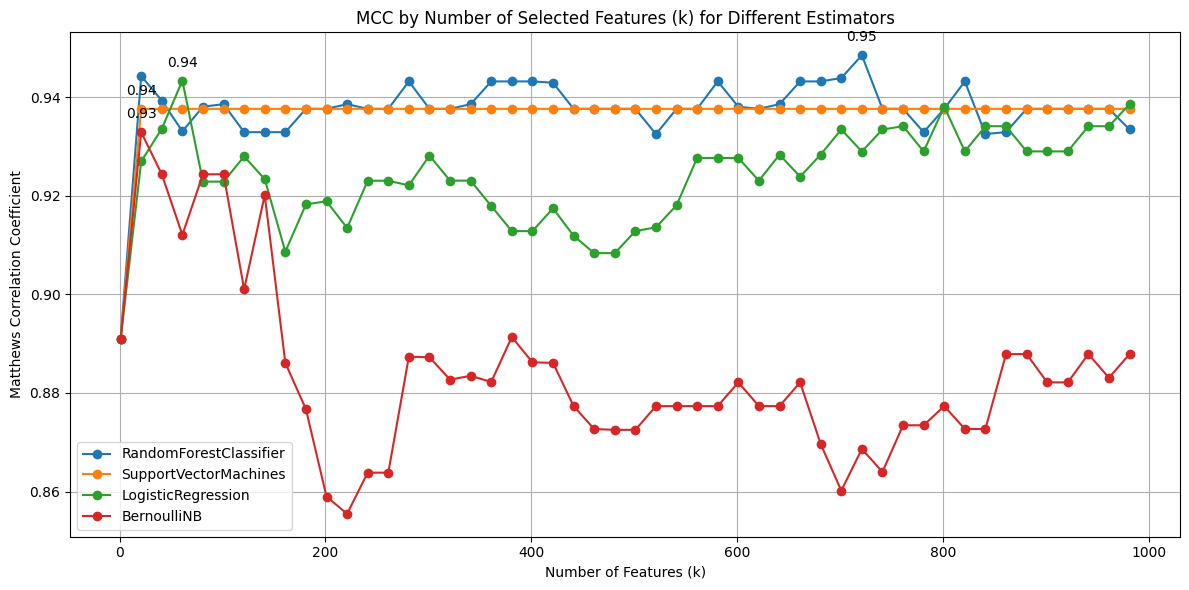

In [4]:
# Define the range of `k` values to explore
k_values = range(1, 1000, 20)

# Define estimators to compare
estimators = {
    'RandomForestClassifier': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'SupportVectorMachines': SVC(),
    'LogisticRegression': LogisticRegression(),
    'BernoulliNB': BernoulliNB()
}

# Prepare to store only MCC results
results = {name: {'mcc': []} for name in estimators}

# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=5)

# Loop over each estimator
for name, estimator in estimators.items():
    print(f"Processing estimator: {name}")
    for k in k_values:
        # build pipeline
        pipeline = Pipeline([
            ('select_k', SelectKBest(f_classif, k=k)),
            ('estimator', estimator)
        ])
        # just MCC
        mcc_scores = cross_val_score(
            pipeline, X_train, Y_train, 
            cv=cv, 
            scoring=make_scorer(matthews_corrcoef), 
            n_jobs=-1
        )
        results[name]['mcc'].append(mcc_scores.mean())

# Plot only MCC
fig, ax = plt.subplots(figsize=(12, 6))
for name, scores in results.items():
    ks = list(k_values)
    mccs = scores['mcc']
    ax.plot(ks, mccs, marker='o', linestyle='-', label=name)
    
    # annotate best MCC
    best_idx = np.argmax(mccs)
    best_k   = ks[best_idx]
    best_mcc = mccs[best_idx]
    ax.annotate(
        f'{best_mcc:.2f}', 
        (best_k, best_mcc),
        textcoords="offset points", 
        xytext=(0,10), 
        ha='center'
    )

ax.set_title('MCC by Number of Selected Features (k) for Different Estimators')
ax.set_xlabel('Number of Features (k)')
ax.set_ylabel('Matthews Correlation Coefficient')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


Pearson Correlation Coefficient: 0.310


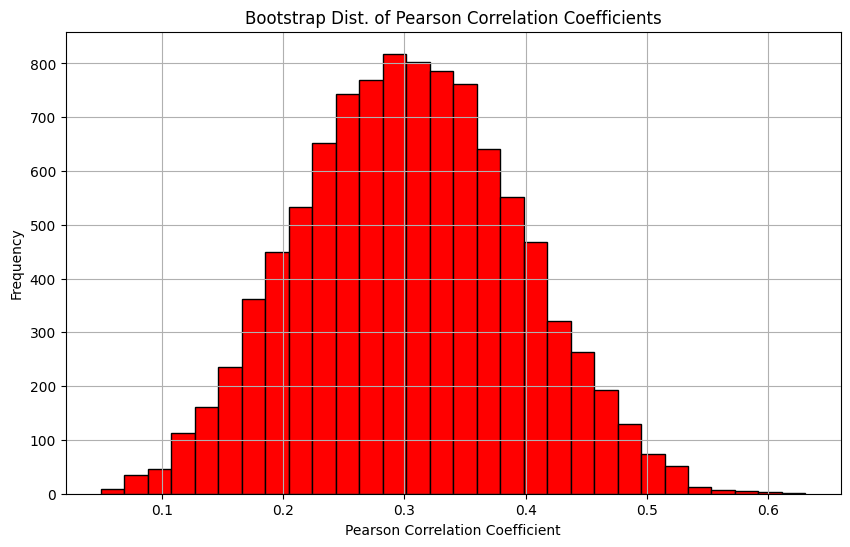

In [8]:
''' Pearson R for correlation coefficient between feature importance scores (From both models)'''


lr_model = LogisticRegression(solver='liblinear', penalty="l1")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)


lr_model.fit(X_aligned, Y_aligned)
rf_model.fit(X_aligned, Y_aligned)


logistic_importance = np.abs(lr_model.coef_[0])
rf_feature_importance = rf_model.feature_importances_

# Pearson correlation
pearson_corr, p_value = pearsonr(logistic_importance, rf_feature_importance)

print(f"Pearson Correlation Coefficient: {pearson_corr:.3f}")


# Bootstrap Pearson correlation coefficients
n_bootstraps = 10000
corr_coefficients = []

for _ in range(n_bootstraps):
    # Sample indices with replacement
    indices = resample(np.arange(len(logistic_importance)))
    
    # Calculate Pearson correlation for the sample
    r, _ = pearsonr(logistic_importance[indices], rf_feature_importance[indices])
    corr_coefficients.append(r)

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(corr_coefficients, bins=30, color='red', edgecolor='black')
plt.title('Bootstrap Dist. of Pearson Correlation Coefficients')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()